In [ ]:
# Feed in masked src's then try to predict the src regressively

In [1]:
import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from ShortSeqHRIRDataset import ShortSeqHRIRDataset
from MaskAutoregressive import MaskAutoregressive
import matplotlib.pyplot as plt
sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
hrir_dataset = ShortSeqHRIRDataset()
for i in range(1,40):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))
len(hrir_dataset)

7128

In [2]:

from torch.utils.data import DataLoader
import torch
# model = MainModel()
model = MaskAutoregressive()
# Set the model to training mode
model.train()
num_epochs = 100

# Create the DataLoader
#dataloader = DataLoader(hrir_dataset, batch_size=32, shuffle=True)
device = torch.device('cuda')
model = model.to(device)



# Split the dataset into a training, validation and test set
# 0.8, 0.1, 0.1 respectively
train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.2 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])

# model.load_state_dict(torch.load('/workspace/fourth_year_project/HRTF Models/mask_models/model_4.pth'))
batch_size = 32

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
target_folder = '/workspace/fourth_year_project/HRTF Models/mask_models/'
# Create it if it doesn't exist
import os
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
def mask_values(tensor, mask_value, mask_num):
    """
    Masks `mask_num` values in a tensor with `mask_value`.

    Args:
    tensor (torch.Tensor): The input tensor.
    mask_value (float): The value to use for masking.
    mask_num (int): The number of values to mask in the tensor.

    Returns:
    torch.Tensor: The masked tensor.
    torch.Tensor: The original tensor before masking.
    """
    # Create a mask tensor with the same size as the input tensor
    # The mask tensor has values of 1 where the input tensor is to be masked
    mask = torch.zeros_like(tensor).flatten()
    
    # Choose `mask_num` random indices to mask
    mask_indices = torch.randperm(mask.numel())[:mask_num]
    mask[mask_indices] = 1.
    mask = mask.reshape(tensor.shape)

    # Create a masked tensor by replacing values where the mask is 1 with `mask_value`
    masked_tensor = tensor * (1 - mask) + mask * mask_value

    return masked_tensor, tensor

import torch
from torch import optim, nn
from torch.optim.lr_scheduler import StepLR

# learning_rate = 0.01
# Define the optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss(reduction='mean')
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Set the model to training mode
model.train()
percent_masked = 0.01
factor = 0.003
number_masked_elements = 5
# myshape = (32, 2, 512)
# Create a weight tensor that has higher values for the early part of the impulse response
# weights = torch.ones_like(myshape)
# weights[:, :200] *= 5  # Increase the weight for the first 200 samples
# # # move to cuda
# weights = weights.to(device)
# torch.autograd.set_detect_anomaly(True)
# Loop over each epoch

best_val_loss = 100000

/workspace/venv_work/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
for epoch in range(1, num_epochs):
    # Initialize the epoch loss
    epoch_loss = 0.0
    model.train()
    # Loop over each batch
    for i, batch in enumerate(dataloader):
        # Get the src and tgt sequences from the batch
        src, _, angle = batch
        # min max normalization to [-1, 1]
        src = 2 * ((src - src.min()) / (src.max() - src.min())) - 1
        src, true_values = mask_values(src, -2, number_masked_elements)
        # mask = (src == -2).float()
        # Masked values are weighted 20 times more
        # weights = mask * 19 + torch.ones_like(src)
        # weights = weights.to(device)
        

        # Move data to the same device as the model
        src = src.to(device)
        angle = angle.to(device)
        true_values = true_values.to(device)
        # print(src.shape, tgt.shape, angle.shape)
        # convert to floats
        angle = angle.float()
        src = src.float()
        true_values = true_values.float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        output = model(src, angle, true_values)
        
        # remove the last feature dimension from output
        # [batch_size, d_model, seq_length] --> [batch_size, d_model-1, seq_length]
        # output = output[:, :-1, :]
        loss = loss_function(output, true_values)
        # loss = loss * weights
        # loss = loss.mean()
        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the batch loss
        epoch_loss += loss.item()
    val_loss = 0
    scheduler.step()
    # Validate the model
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            src, _, angle = batch
            src = src.to(device)
            # min max normalization to [-1, 1]
            src = 2 * ((src - src.min()) / (src.max() - src.min())) - 1
            src, true_values = mask_values(src, -2, number_masked_elements)
            # mask = (src == -2).float()
            # Masked values are weighted 10 times more
            # weights = mask * 19 + torch.ones_like(src)
            # weights = weights.to(device)
            angle = angle.to(device)
            angle = angle.float()
            src = src.float()
            true_values = true_values.to(device)
            true_values = true_values.float()
            output = model(src, angle, true_values)
            # remove the last feature dimension from output
            # output = output[:, :-1, :]
            #print("Before loss val: ",output.shape, tgt.shape)
            loss = loss_function(output, true_values)
            # loss = loss * weights
            # loss = loss.mean()
            val_loss += loss.item()
            # if loss/batch_size < 0.0001:
            save_tgt = true_values
            save_angle = angle
            save_src = src
            save_output = output
                # raise ValueError("Loss is too low")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # percent_masked += 0.001 # Add 1 %
        number_masked_elements += 1
    # Print the average loss for this epoch
    print(f'Epoch {epoch} | Training Loss: {epoch_loss / len(dataloader)} | Validation Loss: {val_loss / len(val_loader)} | Learning Rate: {scheduler.get_last_lr()} | Elements Masked: {number_masked_elements}')
    if epoch % 2 == 0:
        torch.save(model.state_dict(), f'{target_folder}model_{epoch}.pth')

RuntimeError: The expanded size of the tensor (3) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [32, 3].  Tensor sizes: [32, 2]

In [5]:
# model = StraightPredictor()
# model = model.to(device)
# model.load_state_dict(torch.load('/workspace/fourth_year_project/HRTF Models/full_seq_models/model_175.pth'))

save_tgt, save_angle, save_src, save_output = save_tgt.to('cpu'), save_angle.to('cpu'), save_src.to('cpu'), save_output.to('cpu')

NameError: name 'save_tgt' is not defined

In [4]:
print(save_tgt.shape, save_angle.shape, save_src.shape, save_output.shape)

torch.Size([32, 2, 512]) torch.Size([32]) torch.Size([32, 2, 512]) torch.Size([32, 2, 512])


In [5]:
index = 0

t1, s1, o1 = save_tgt[index,0,:], save_src[index,0,:], save_output[index,0,:]
print(t1.shape, s1.shape, o1.shape)

torch.Size([512]) torch.Size([512]) torch.Size([512])


In [6]:
print(loss_function(save_tgt, save_output).mean())

tensor(0.0036)


Text(0.5, 1.0, 'Output')

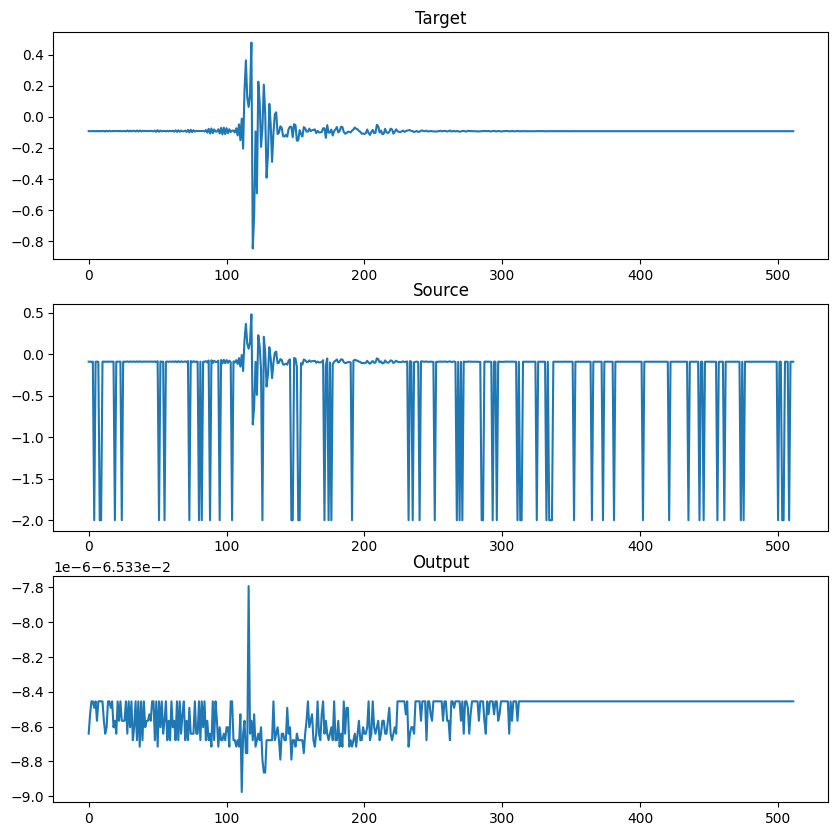

In [7]:
# Plot t1, s1, o1 on their own subplots
# create subplot
fig, ax = plt.subplots(3, 1, figsize=(10,10))


ax[0].plot(t1)
ax[0].set_title('Target')
ax[1].plot(s1)
ax[1].set_title('Source')
ax[2].plot(o1)
ax[2].set_title('Output')


In [18]:
# model.load_state_dict(torch.load('/workspace/fourth_year_project/HRTF Models/mask_models/model_16.pth'))

<All keys matched successfully>

tensor(0.4242, device='cuda:0', grad_fn=<MseLossBackward0>)

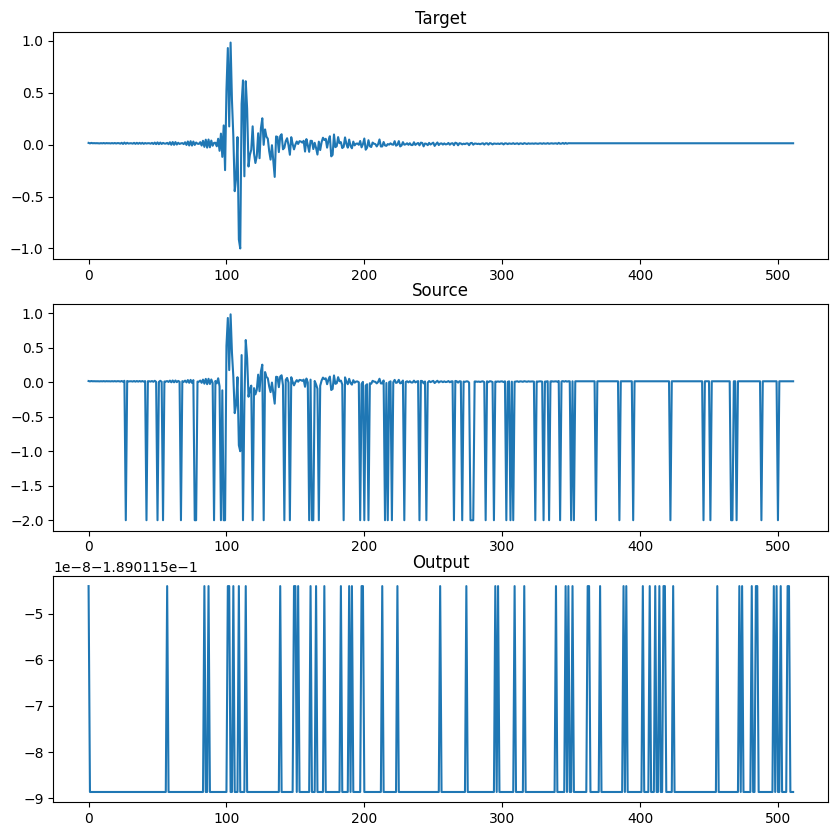

In [9]:
# load in 1 sample from test set
sample = next(iter(dataloader))
src, tgt, angle = sample
src = src.to(device)
tgt = tgt.to(device)
angle = angle.to(device)
angle = angle.float()
src = src.float()
tgt = tgt.float()

# Get first sample from batch
src = src[0]
src = 2 * ((src - src.min()) / (src.max() - src.min())) - 1
tgt, true_values =  mask_values(src, -2, percent_masked)
# src = true_values
angle = angle[0]

# Standardize the input
# src = (src - src.mean()) / src.std()

# tgt = (tgt - tgt.mean()) / tgt.std()
# tgt = 2 * ((tgt - tgt.min()) / (tgt.max() - tgt.min())) - 1
# Divide angle by 360 to get a value between 0 and 1
angle = angle / 360
test_loss_func = nn.MSELoss()
# print(src.shape, angle.shape, tgt.shape)
# print(angle)
# With target
output = model(src.unsqueeze(0), angle.unsqueeze(0), tgt=tgt.unsqueeze(0))
output  = output.squeeze(0)
output.shape
fig, ax = plt.subplots(3, 1, figsize=(10,10))


ax[0].plot(src[0].cpu().detach().numpy())
ax[0].set_title('Target')
ax[1].plot(tgt[0].cpu().detach().numpy())
ax[1].set_title('Source')
ax[2].plot(output[0].cpu().detach().numpy())
ax[2].set_title('Output')

plt.plot()
tlf = nn.MSELoss()
tlf(output[:-1, :], tgt)